# Generate tessellation diagram

Computational notebook 01 for **Morphological tessellation as a way of partitioning space: Improving consistency in urban morphology at the plot scale**.


Fleischmann, M., Feliciotti, A., Romice, O. and Porta, S. (2020) _‘Morphological tessellation as a way of partitioning space: Improving consistency in urban morphology at the plot scale’_, Computers, Environment and Urban Systems, 80, p. 101441. doi: [10.1016/j.compenvurbsys.2019.101441](http://doi.org/10.1016/j.compenvurbsys.2019.101441).

Archived version of this repository is stored at the University of Strathclyde KnowledgeBase at DOI [10.15129/c766db26-3fa8-45c6-8218-098d529571fc](https://doi.org/10.15129/c766db26-3fa8-45c6-8218-098d529571fc).


Contact: martin@martinfleischmann.net

Date: 27/03/2020

Note: notebook has been cleaned and released retroactively. It is likely that different versions of packages were initially used, but we made sure that the results remained unaltered.

---
**Description**

This notebook generates diagrams illustrating the principles of morphological tessellation used to prepare figures 2, 3 and 4. Figures were later post-processed in Illustrator.

In [1]:
import geopandas as gpd
import momepy as mm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
from random import random
import shapely
from shapely.wkt import loads
from shapely.geometry import Polygon, Point
from tqdm import tqdm

In [2]:
gpd.__version__, mm.__version__, matplotlib.__version__, sns.__version__, np.__version__, sp.__version__, shapely.__version__

('0.7.0', '0.1.1', '3.2.1', '0.10.0', '1.18.1', '1.4.1', '1.7.0')

In [3]:
polys = [
    Polygon([(10, 10), (20, 10), (20, 20), (10, 20)]),
    Polygon([(30, 10), (40, 10), (40, 20), (30, 20)]),
    Polygon([(10, 30), (20, 30), (20, 40), (10, 40)]),
    Polygon([(20, 30), (30, 30), (30, 40), (20, 40)]),
    Polygon([(30, 30), (40, 30), (40, 40), (30, 40)]),
]

In [4]:
gdf = gpd.GeoDataFrame(geometry=polys)
gdf['uID'] = mm.unique_id(gdf)
retain = gdf.copy()

In [5]:
sns.set_style('whitegrid')
sns.set_context(context='paper', font_scale=1, rc=None)

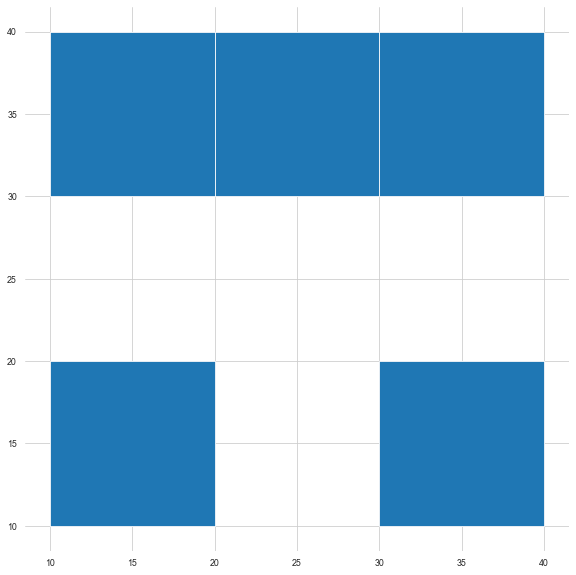

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_0.svg')

In [7]:
limit = Polygon([(0, 0), (50, 0), (50, 50), (0, 50)])

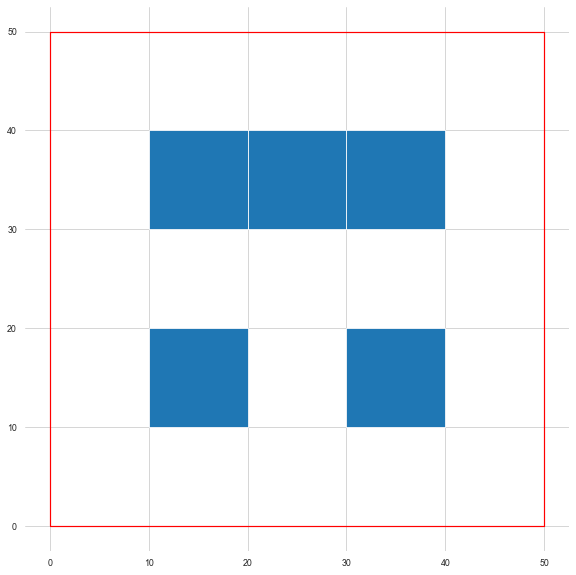

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
gpd.GeoDataFrame(geometry=[limit.boundary]).plot(ax=ax, edgecolor='red')
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_1.svg')

In [9]:
shrink = 1

In [10]:
polys = ["Polygon", "MultiPolygon"]
print("Bufferring geometry...")
gdf["geometry"] = gdf.geometry.apply(
    lambda g: g.buffer(-shrink, cap_style=2, join_style=2) if g.type in polys else g
)

Bufferring geometry...


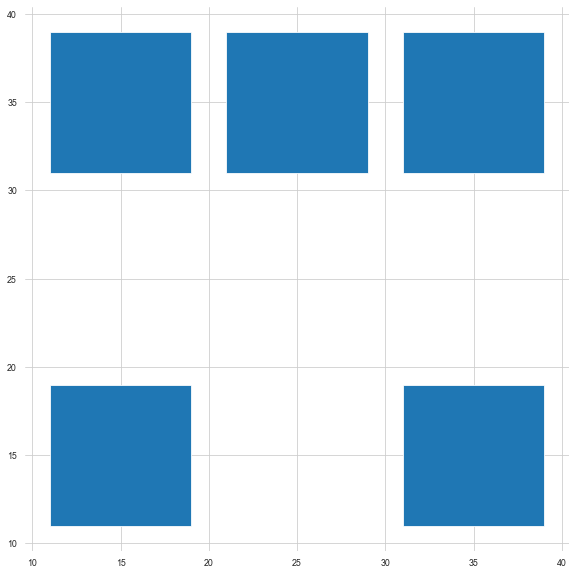

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_2.svg')

In [12]:
segment = 2

In [13]:
def _densify(geom, segment):
        """
        Returns densified geoemtry with segments no longer than `segment`.
        """
        from osgeo import ogr
        poly = geom
        wkt = geom.wkt  # shapely Polygon to wkt
        geom = ogr.CreateGeometryFromWkt(wkt)  # create ogr geometry
        geom.Segmentize(segment)  # densify geometry by set metres
        geom.CloseRings()  # fix for GDAL 2.4.1 bug
        wkt2 = geom.ExportToWkt()  # ogr geometry to wkt
        new = loads(wkt2)  # wkt to shapely Polygon
        return new

gdf["geometry"] = gdf["geometry"].apply(_densify, segment=segment)

In [14]:
def _point_array(objects, unique_id):
        """
        Returns lists of points and ids based on geometry and unique_id.
        """
        points = []
        ids = []
        for idx, row in tqdm(objects.iterrows(), total=objects.shape[0]):
            if row["geometry"].type in ["Polygon", "MultiPolygon"]:
                poly_ext = row["geometry"].boundary
            else:
                poly_ext = row["geometry"]
            if poly_ext is not None:
                if poly_ext.type == "MultiLineString":
                    for line in poly_ext:
                        point_coords = line.coords
                        row_array = np.array(point_coords[:-1]).tolist()
                        for i, a in enumerate(row_array):
                            points.append(row_array[i])
                            ids.append(row[unique_id])
                elif poly_ext.type == "LineString":
                    point_coords = poly_ext.coords
                    row_array = np.array(point_coords[:-1]).tolist()
                    for i, a in enumerate(row_array):
                        points.append(row_array[i])
                        ids.append(row[unique_id])
                else:
                    raise Exception("Boundary type is {}".format(poly_ext.type))
        return points, ids

points, ids = _point_array(gdf, 'uID')

100%|██████████| 5/5 [00:00<00:00, 309.33it/s]


In [15]:
pts = [Point(p) for p in points]

In [16]:
pts = gpd.GeoDataFrame(geometry=pts)

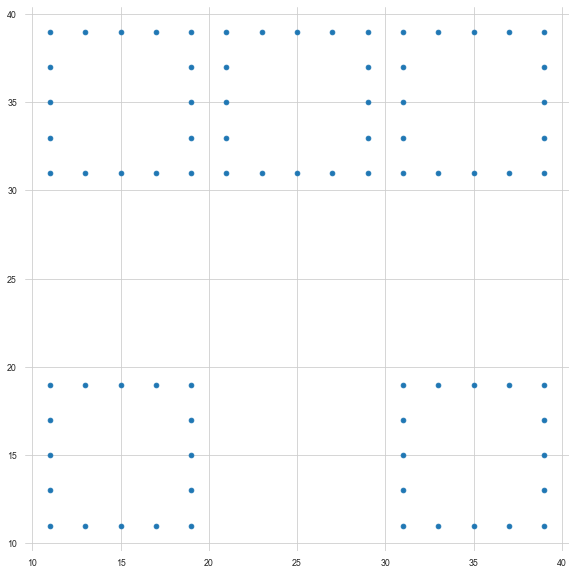

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
pts.plot(ax=ax)
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_3.svg')

In [18]:
hull = limit.buffer(100)
hull = _densify(hull, 10)
hull_array = np.array(hull.boundary.coords).tolist()
for i, a in enumerate(hull_array):
    points.append(hull_array[i])
    ids.append(-1)

In [19]:
voronoi_diagram = Voronoi(np.array(points))

In [20]:
def _regions(voronoi_diagram, unique_id, ids, crs):
        """
        Generate GeoDataFrame of Voronoi regions from scipy.spatial.Voronoi.
        """
        # generate DataFrame of results
        regions = pd.DataFrame()
        regions[unique_id] = ids  # add unique id
        regions["region"] = voronoi_diagram.point_region  # add region id for each point

        # add vertices of each polygon
        vertices = []
        for region in regions.region:
            vertices.append(voronoi_diagram.regions[region])
        regions["vertices"] = vertices

        # convert vertices to Polygons
        polygons = []
        for region in tqdm(regions.vertices, desc="Vertices to Polygons"):
            if -1 not in region:
                polygons.append(Polygon(voronoi_diagram.vertices[region]))
            else:
                polygons.append(None)
        # save polygons as geometry column
        regions["geometry"] = polygons

        # generate GeoDataFrame
        regions_gdf = gpd.GeoDataFrame(regions.dropna(), geometry="geometry")
        regions_gdf = regions_gdf.loc[
            regions_gdf["geometry"].length < 1000000
        ]  # delete errors
        regions_gdf = regions_gdf.loc[
            regions_gdf[unique_id] != -1
        ]  # delete hull-based cells
        regions_gdf.crs = crs
        return regions_gdf

regions_gdf = _regions(voronoi_diagram, 'uID', ids, crs=gdf.crs)

Vertices to Polygons: 100%|██████████| 165/165 [00:00<00:00, 20650.50it/s]


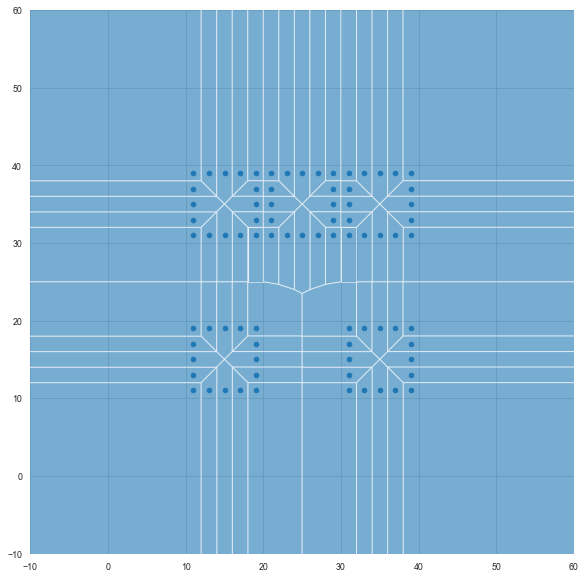

In [21]:
f, ax = plt.subplots(figsize=(10, 10))
regions_gdf.plot(ax=ax, alpha=.6, edgecolor='white', linewidth=1)
pts.plot(ax=ax)
ax.set_xlim(-10, 60)
ax.set_ylim(-10, 60)
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_4.svg')

In [22]:
morphological_tessellation = regions_gdf[['uID', "geometry"]].dissolve(
        by='uID', as_index=False
    )

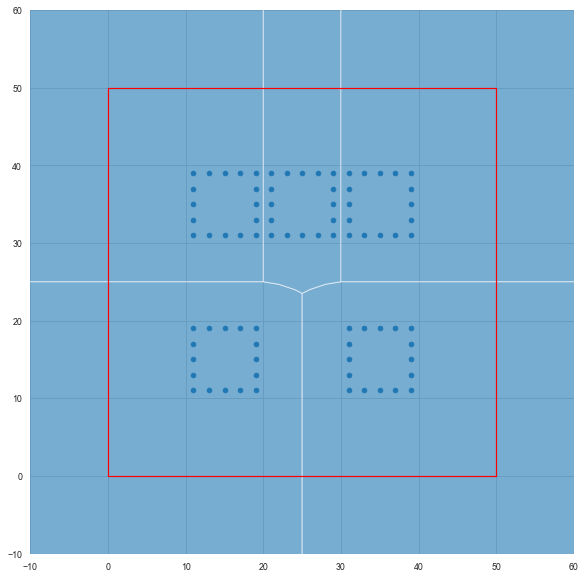

In [23]:
f, ax = plt.subplots(figsize=(10, 10))
morphological_tessellation.plot(ax=ax, alpha=.6, edgecolor='white', linewidth=1)
pts.plot(ax=ax)
ax.set_xlim(-10, 60)
ax.set_ylim(-10, 60)
gpd.GeoDataFrame(geometry=[limit.boundary]).plot(ax=ax, edgecolor='red')
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_5.svg')

In [24]:
morphological_tessellation = gpd.clip(morphological_tessellation, limit)

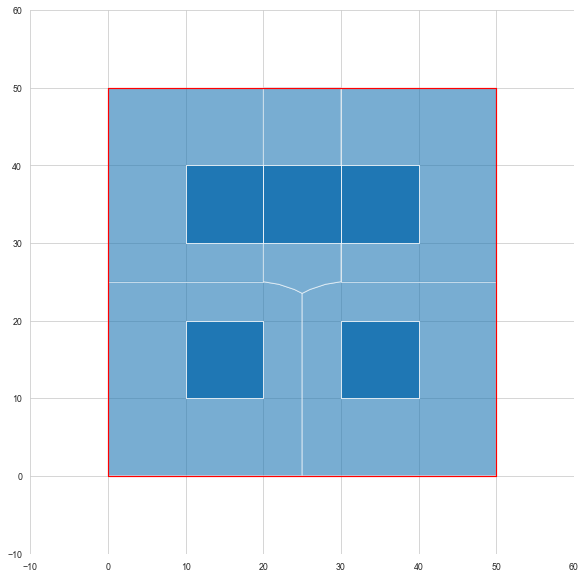

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
morphological_tessellation.plot(ax=ax, alpha=.6, edgecolor='white', linewidth=1)
retain.plot(ax=ax)
ax.set_xlim(-10, 60)
ax.set_ylim(-10, 60)
gpd.GeoDataFrame(geometry=[limit.boundary]).plot(ax=ax, edgecolor='red')
sns.despine(left=True, bottom=True)
#plt.savefig('tesdiag_6.svg')

# Saw-like diagram

In [26]:
polys = [
    Polygon([(10, 30), (20, 30), (20, 40), (10, 40)]),
    Polygon([(20, 31), (30, 31), (30, 41), (20, 41)]),
    Polygon([(30, 30), (40, 30), (40, 40), (30, 40)]),
]

In [27]:
gdf = gpd.GeoDataFrame(geometry=polys)
gdf['uID'] = mm.unique_id(gdf)
retain = gdf.copy()

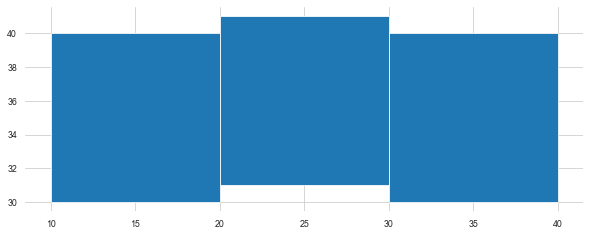

In [28]:
f, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
sns.despine(left=True, bottom=True)
#plt.savefig('sawdiag_0.svg')

In [29]:
polys = ["Polygon", "MultiPolygon"]
print("Bufferring geometry...")
shrink = 0.3
gdf["geometry"] = gdf.geometry.apply(
    lambda g: g.buffer(-shrink, cap_style=2, join_style=2) if g.type in polys else g
)

Bufferring geometry...


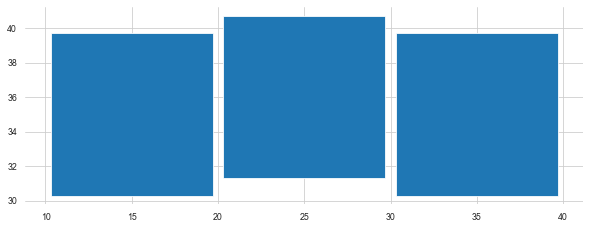

In [30]:
f, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
sns.despine(left=True, bottom=True)
#plt.savefig('sawdiag_1.svg')

In [31]:
gdf["geometry"] = gdf["geometry"].apply(_densify, segment=segment)

In [32]:
points, ids = _point_array(gdf, 'uID')
pts = [Point(p) for p in points]
pts = gpd.GeoDataFrame(geometry=pts)

100%|██████████| 3/3 [00:00<00:00, 655.91it/s]


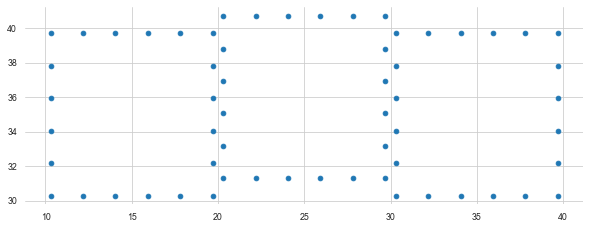

In [33]:
f, ax = plt.subplots(figsize=(10, 10))
pts.plot(ax=ax)
sns.despine(left=True, bottom=True)
#plt.savefig('sawdiag_2.svg')

In [34]:
hull = limit.buffer(100)
hull = _densify(hull, 10)
hull_array = np.array(hull.boundary.coords).tolist()
for i, a in enumerate(hull_array):
    points.append(hull_array[i])
    ids.append(-1)

In [35]:
voronoi_diagram = Voronoi(np.array(points))
regions_gdf = _regions(voronoi_diagram, 'uID', ids, crs=gdf.crs)

Vertices to Polygons: 100%|██████████| 145/145 [00:00<00:00, 28013.55it/s]


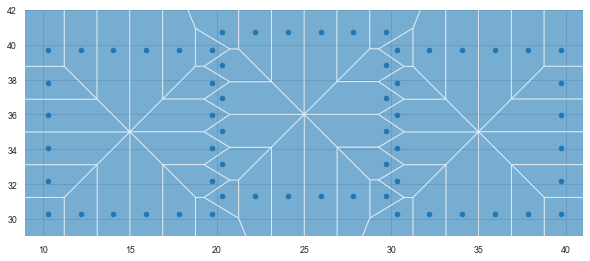

In [36]:
f, ax = plt.subplots(figsize=(10, 10))
regions_gdf.plot(ax=ax, alpha=.6, edgecolor='white', linewidth=1)
pts.plot(ax=ax)
ax.set_xlim(9, 41)
ax.set_ylim(29, 42)
sns.despine(left=True, bottom=True)
#plt.savefig('sawdiag_3.svg')

In [37]:
morphological_tessellation = regions_gdf[['uID', "geometry"]].dissolve(
        by='uID', as_index=False
    )

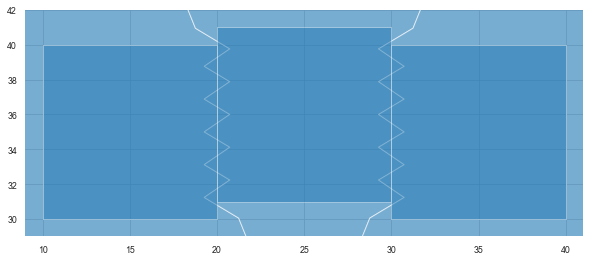

In [38]:
f, ax = plt.subplots(figsize=(10, 10))
morphological_tessellation.plot(ax=ax, alpha=.6, edgecolor='white', linewidth=1)
retain.plot(ax=ax, alpha=.5)
ax.set_xlim(9, 41)
ax.set_ylim(29, 42)
sns.despine(left=True, bottom=True)
#plt.savefig('sawdiag_4.svg')

In [39]:
shrink = 0.4
segment = 0.5

In [40]:
polys = ["Polygon", "MultiPolygon"]
print("Bufferring geometry...")
gdf["geometry"] = gdf.geometry.apply(
    lambda g: g.buffer(-shrink, cap_style=2, join_style=2) if g.type in polys else g
)

Bufferring geometry...


In [41]:
gdf["geometry"] = gdf["geometry"].apply(_densify, segment=segment)

In [43]:
points, ids = _point_array(gdf, 'uID')
hull = limit.buffer(100)
hull = _densify(hull, 10)
hull_array = np.array(hull.boundary.coords).tolist()
for i, a in enumerate(hull_array):
    points.append(hull_array[i])
    ids.append(-1)

100%|██████████| 3/3 [00:00<00:00, 300.75it/s]


In [44]:
voronoi_diagram = Voronoi(np.array(points))
regions_gdf = _regions(voronoi_diagram, 'uID', ids, crs=gdf.crs)
morphological_tessellation = regions_gdf[['uID', "geometry"]].dissolve(
        by='uID', as_index=False
    )

Vertices to Polygons: 100%|██████████| 301/301 [00:00<00:00, 28233.42it/s]


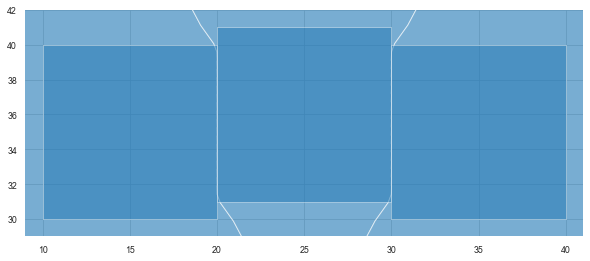

In [45]:
f, ax = plt.subplots(figsize=(10, 10))
morphological_tessellation.plot(ax=ax, alpha=.6, edgecolor='white', linewidth=1)
retain.plot(ax=ax, alpha=.5)
ax.set_xlim(9, 41)
ax.set_ylim(29, 42)
sns.despine(left=True, bottom=True)
#plt.savefig('sawdiag_5.svg')

## Voronoi tessellation illustration

In [56]:
points = np.array(
    [[random(), random()] for _ in range(15)])

In [57]:
vor = Voronoi(points)

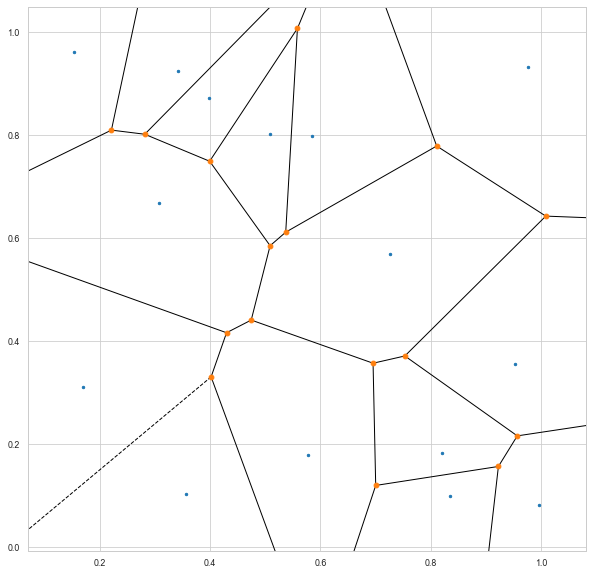

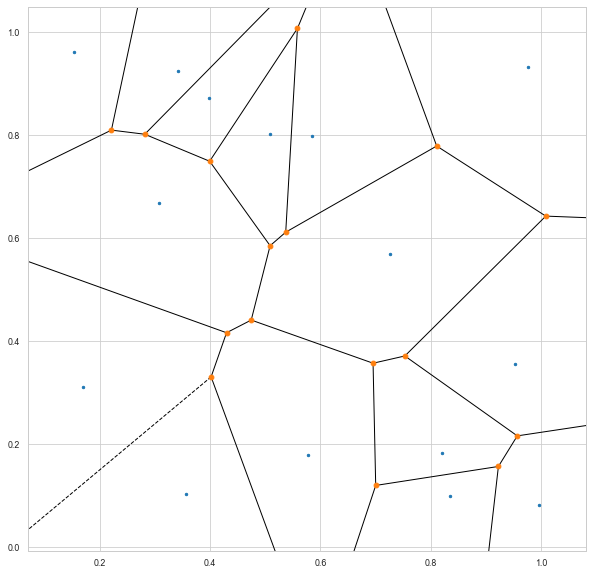

In [58]:
voronoi_plot_2d(vor)
#plt.savefig("voro_allpts.svg")